In [1]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

%env WORKDIR=/Users/jitang/Dev/workdir

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import cartopy.crs as ccrs

from lib.reanalysis import r1
from lib import obs
from lib.plotting import maps
from lib.enso import oni_trimonthly

env: WORKDIR=/Users/jitang/Dev/workdir


In [596]:
sfo = obs.daily_summary('SFO', '1980-07-01', '2021-06-01')
sfo.loc[sfo.day == '2008-01-03', 'precip_in'] = 0.17
sfo.loc[sfo.day == '2008-01-04', 'precip_in'] = 2.10
sfo.loc[sfo.day == '2008-01-05', 'precip_in'] = 0.77
sfo.loc[sfo.precip_in < 0.1, 'precip_in'] = 0

data_cols = ['day', 'precip_in', 'max_temp_f', 'min_temp_f']

sfo_monthly = sfo[data_cols].resample('MS', on='day').agg({
    'precip_in': np.sum,
    'max_temp_f': np.mean,
    'min_temp_f': np.mean
}).reset_index()

djf = sfo_monthly[sfo_monthly.day.dt.month.isin([12, 1, 2, 3])]

In [597]:
djf.precip_in.describe()

count    164.000000
mean       3.397195
std        2.757524
min        0.000000
25%        1.205000
50%        2.780000
75%        5.175000
max       13.520000
Name: precip_in, dtype: float64

In [598]:
# wet_top50 = djf[djf.precip_in > djf.precip_in.mean() + 0.5*djf.precip_in.std()]
# wet_top50.shape

wet_top50 = djf.sort_values(by='precip_in', ascending=False).head(50)
wet_top50.shape

(50, 4)

In [599]:
oni = oni_trimonthly()
wet_top50['month'] = wet_top50.day.dt.month
wet_top50['year'] = wet_top50.day.dt.year

oni_relevant = oni[['ANOM', 'MONTH', 'YR']]
oni_relevant.columns = ['ONI', 'month', 'year']
wet_top50 = wet_top50.merge(oni_relevant)

In [600]:
bbox = (0, 360, 90, 10)
_, _, wet_anoms = r1.hgt_monthly(500, yearmonths=wet_top50.day, bbox=bbox)

In [601]:
solver = Eof(wet_anoms.hgt)

# retrieve the first two EOFs from the solver class
eofs = solver.eofs(neofs=3)

In [602]:
solver.varianceFraction(neigs=3)

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.27672106, 0.13757406, 0.11416934], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

In [603]:
def plot_nhem_anoms(da, cmap, levels, title, draw=True, colorbar_label='Geopotential height anomaly (dm)'):
    proj = ccrs.NorthPolarStereo(central_longitude=-94.5, true_scale_latitude=None, globe=None)
    m = maps.CartopyMap(proj=proj)
    if draw:
        m.draw()
    m.plot.fill(da, cmap, levels, colorbar=True, colorbar_label=colorbar_label)
    m.textbox.bottom_right(title, fontsize=20)
    m.textbox.top_left('by Jim Tang (@wxmann)', fontsize=16)
    return m

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


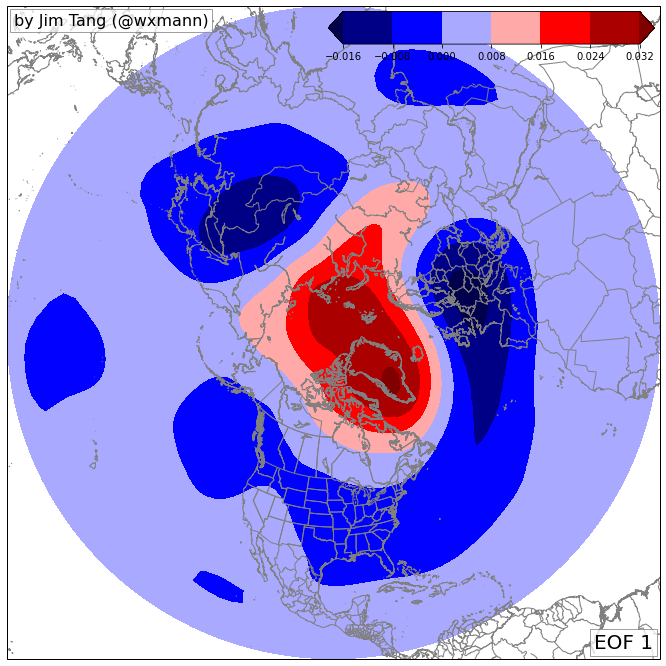

In [604]:
fig = plt.figure(figsize=(12, 12))

da = eofs[0]
cmap = 'seismic'
title = 'EOF 1'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

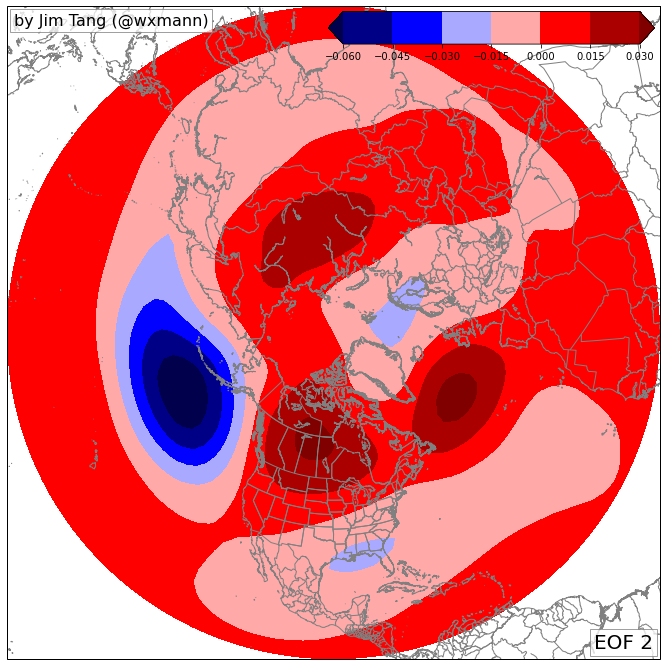

In [605]:
fig = plt.figure(figsize=(12, 12))

da = eofs[1]
cmap = 'seismic'
title = 'EOF 2'

m = plot_nhem_anoms(da, cmap, levels=None, title=title, draw=True, colorbar_label=None)

In [606]:
pcs = solver.pcs(pcscaling=1, npcs=2).to_dataframe().reset_index()
first_pc = pcs[pcs['mode'] == 0]
second_pc = pcs[pcs['mode'] == 1]
wet_with_pcs = wet_top50.merge(
    first_pc[['time', 'pcs']], left_on='day', right_on='time').merge(
    second_pc[['time', 'pcs']], on='time')

wet_with_pcs = wet_with_pcs.rename(columns={
    'pcs_x': 'pc1',
    'pcs_y': 'pc2'
})

In [607]:
in_djf = wet_with_pcs.day.dt.month.isin([12, 1, 2])
wet_with_pcs_djf = wet_with_pcs[in_djf]

in_djfm = wet_with_pcs.day.dt.month.isin([12, 1, 2, 3])
wet_with_pcs_djfm = wet_with_pcs[in_djfm]

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


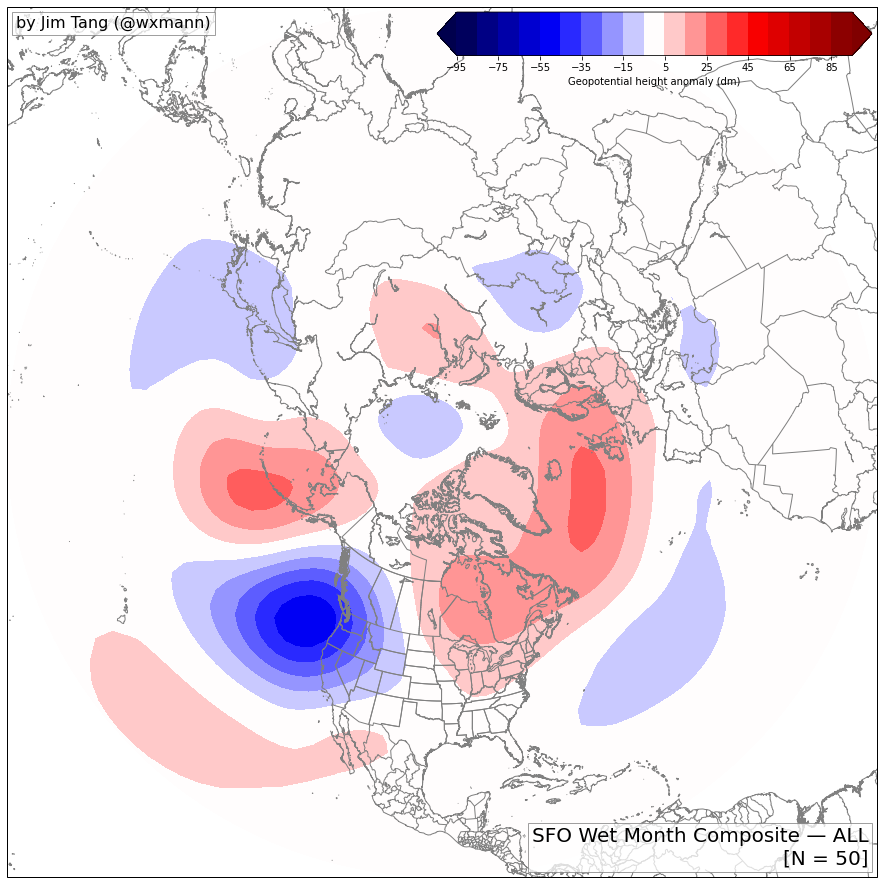

In [631]:
fig = plt.figure(figsize=(16, 16))

_, _, wet_with_pcs_djfm_anoms = r1.hgt_monthly(500, yearmonths=wet_with_pcs_djfm.day, bbox=bbox)
da = wet_with_pcs_djfm_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-95, 96, 10)
title = f'SFO Wet Month Composite — ALL\n[N = {len(wet_with_pcs_djfm.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

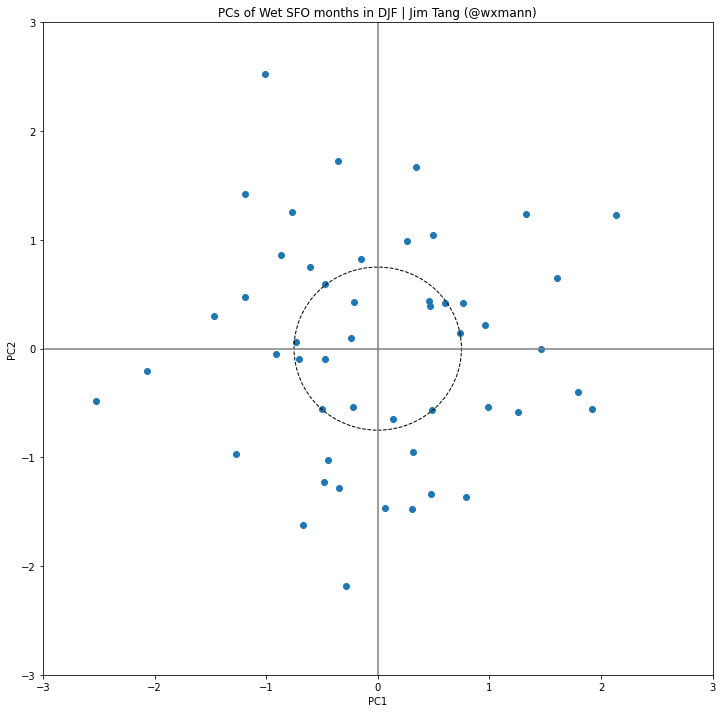

In [609]:
plt.figure(figsize=(12, 12))
plt.scatter(wet_with_pcs_djfm.pc1, wet_with_pcs_djfm.pc2)
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCs of Wet SFO months in DJF | Jim Tang (@wxmann)')
circ = plt.Circle((0, 0), 0.75, color='k', fill=False, ls='--')
plt.gca().add_patch(circ)

## Analysis for just PC2 (Aleutian Region)

In [610]:
# analysis with just pc2 (Aleutian region)
threshold = 0.25

pc2_pos = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 > threshold)]
pc2_neg = wet_with_pcs_djfm[(wet_with_pcs_djfm.pc2 < -threshold)]
_, _, pc2_pos_anoms = r1.hgt_monthly(500, yearmonths=pc2_pos.day, bbox=bbox)
_, _, pc2_neg_anoms = r1.hgt_monthly(500, yearmonths=pc2_neg.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


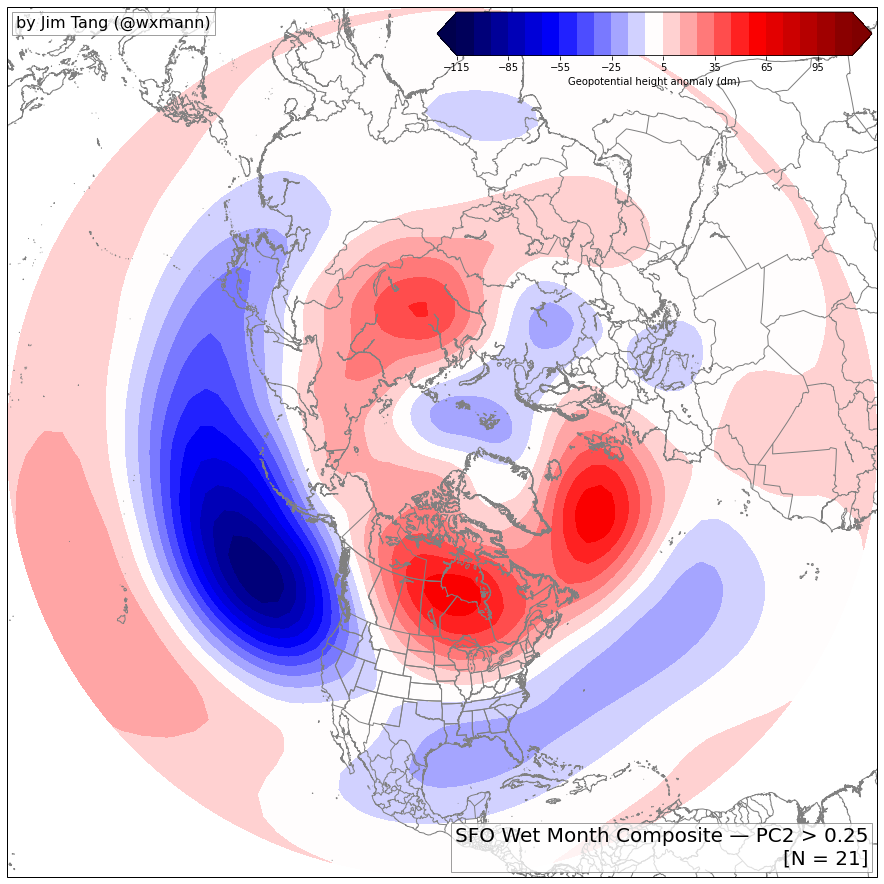

In [611]:
fig = plt.figure(figsize=(16, 16))

da = pc2_pos_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 > {threshold}\n[N = {len(pc2_pos_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


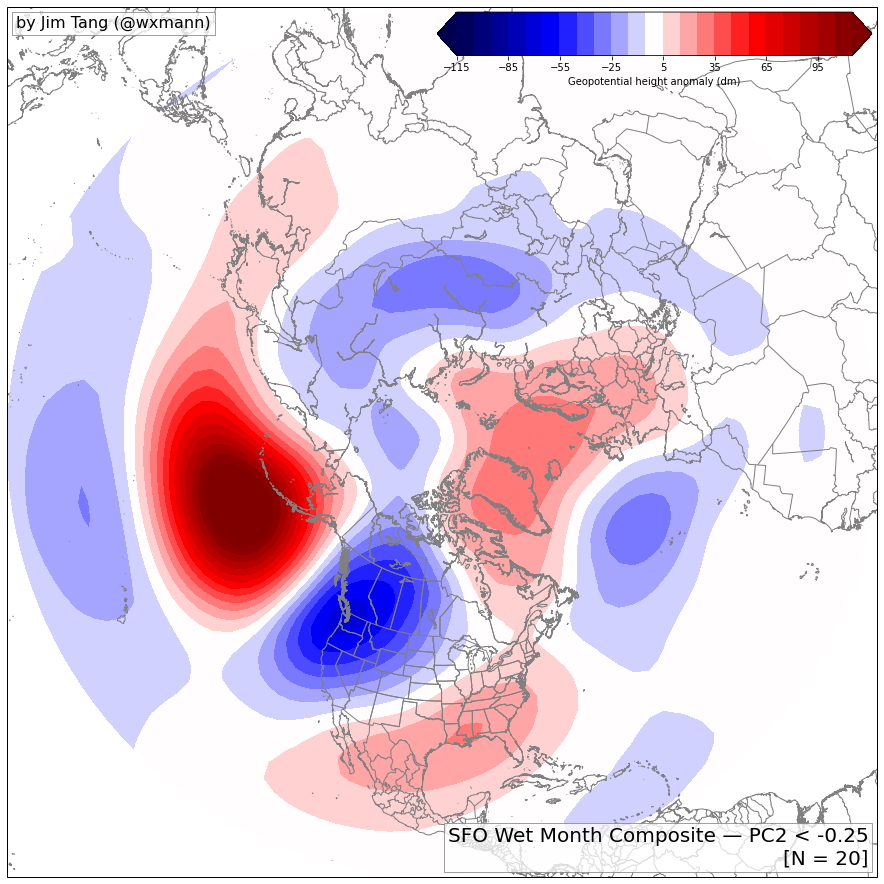

In [612]:
fig = plt.figure(figsize=(16, 16))

da = pc2_neg_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC2 < {-threshold}\n[N = {len(pc2_neg_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

In [613]:
pc2_pos

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
0,1998-02-01,13.52,56.714286,47.750000,2,1998,1.93,1998-02-01,-1.189053,1.421494
2,2014-12-01,10.47,61.580645,51.935484,12,2014,0.66,2014-12-01,0.265425,0.991563
7,1995-01-01,8.76,56.064516,48.419355,1,1995,0.96,1995-01-01,0.492081,1.046950
8,1995-03-01,8.63,60.032258,47.677419,3,1995,0.53,1995-03-01,-0.208940,0.429001
9,2001-12-01,8.27,56.032258,47.258065,12,2001,-0.31,2001-12-01,0.766529,0.421736
10,1983-03-01,8.26,59.000000,49.193548,3,1983,1.54,1983-03-01,0.345407,1.666742
11,2005-12-01,8.17,59.032258,47.870968,12,2005,-0.84,2005-12-01,1.326620,1.239700
12,2000-02-01,8.15,57.827586,48.793103,2,2000,-1.41,2000-02-01,-0.147821,0.828699
13,1986-02-01,7.87,62.142857,50.642857,2,1986,-0.47,1986-02-01,0.463357,0.442499
14,1998-01-01,7.77,57.290323,48.516129,1,1998,2.24,1998-01-01,1.604966,0.650645


In [614]:
pc2_neg

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
1,1993-01-01,11.07,55.225806,42.967742,1,1993,0.09,1993-01-01,-2.523243,-0.478663
3,2008-01-01,9.87,53.036774,43.682581,1,2008,-1.64,2008-01-01,-0.446672,-1.020879
6,1982-01-01,8.80,51.161290,38.967742,1,1982,-0.05,1982-01-01,0.315093,-0.953038
15,1982-03-01,7.49,56.935484,45.451613,3,1982,0.19,1982-03-01,-0.346280,-1.281874
17,2017-02-01,7.24,59.785714,49.178571,2,2017,-0.16,2017-02-01,-0.223094,-0.534472
18,2019-02-01,7.20,55.892857,44.071429,2,2019,0.72,2019-02-01,-0.671778,-1.618002
19,1996-01-01,6.84,57.064516,46.580645,1,1996,-0.90,1996-01-01,0.303072,-1.473808
22,1996-12-01,6.49,58.870968,49.290323,12,1996,-0.49,1996-12-01,0.987186,-0.535324
25,2009-02-01,6.24,58.107143,46.035714,2,2009,-0.79,2009-02-01,0.793884,-1.363623
26,2012-12-01,6.23,57.290323,46.387097,12,2012,-0.21,2012-12-01,1.259343,-0.584938


In [615]:
wet_with_pcs_djf[wet_with_pcs_djf.pc2.abs() < 0.25]

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
4,2002-12-01,9.37,57.774194,47.612903,12,2002,1.14,2002-12-01,0.736944,0.146873
5,2017-01-01,9.19,56.451613,43.709677,1,2017,-0.34,2017-01-01,-0.707476,-0.096929
24,2004-12-01,6.26,58.000000,46.290323,12,2004,0.69,2004-12-01,-0.909202,-0.046062
27,1992-02-01,6.22,62.655172,49.275862,2,1992,1.63,1992-02-01,-0.729381,0.065403
29,1983-12-01,6.03,57.258065,49.548387,12,1983,-0.91,1983-12-01,-0.238103,0.101422
36,1996-02-01,5.75,60.310345,49.172414,2,1996,-0.75,1996-02-01,-0.476905,-0.096020
44,2005-02-01,4.82,60.357143,49.571429,2,2005,0.58,2005-02-01,0.958774,0.212885
45,2018-01-01,4.82,59.129032,48.096774,1,2018,-0.92,2018-01-01,1.459969,-0.006932


Text(2.2, 2.5, 'El Nino')

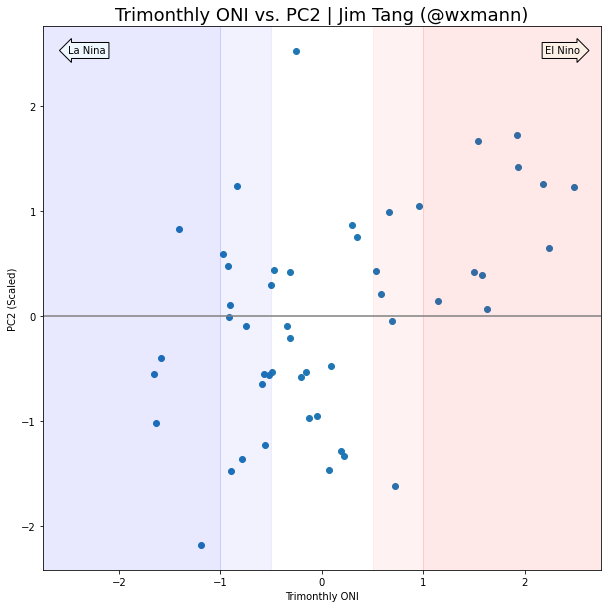

In [616]:
plt.figure(figsize=(10, 10))

plt.scatter(wet_with_pcs_djfm.ONI, wet_with_pcs_djfm.pc2)
plt.title('Trimonthly ONI vs. PC2 | Jim Tang (@wxmann)', fontdict=dict(fontsize=18))
plt.xlabel('Trimonthly ONI')
plt.ylabel('PC2 (Scaled)')
plt.axhline(y=0, color='gray')

# plt.axvline(x=1, color='gray', ls='--')
plt.axvspan(1, 3, color='red', alpha=0.09)

# plt.axvline(x=-1, color='gray', ls='--')
plt.axvspan(-1, -3, color='blue', alpha=0.09)

# plt.axvline(x=0.5, color='gray', ls='--')
plt.axvspan(0.5, 1, color='red', alpha=0.05)

# plt.axvline(x=-0.5, color='gray', ls='--')
plt.axvspan(-0.5, -1, color='blue', alpha=0.05)

plt.xlim([-2.75, 2.75])

plt.text(-2.5, 2.5, 'La Nina', bbox=dict(boxstyle='larrow,pad=0.3', fc='aliceblue'))
plt.text(2.2, 2.5, 'El Nino', bbox=dict(boxstyle='rarrow,pad=0.3', fc='linen'))

{'whiskers': [<matplotlib.lines.Line2D at 0x14b8af430>,
 'caps': [<matplotlib.lines.Line2D at 0x147f75250>,
 'boxes': [<matplotlib.lines.Line2D at 0x14b8af280>,
 'medians': [<matplotlib.lines.Line2D at 0x14b8a7070>,
 'fliers': [<matplotlib.lines.Line2D at 0x14b8a7790>,
 'means': []}

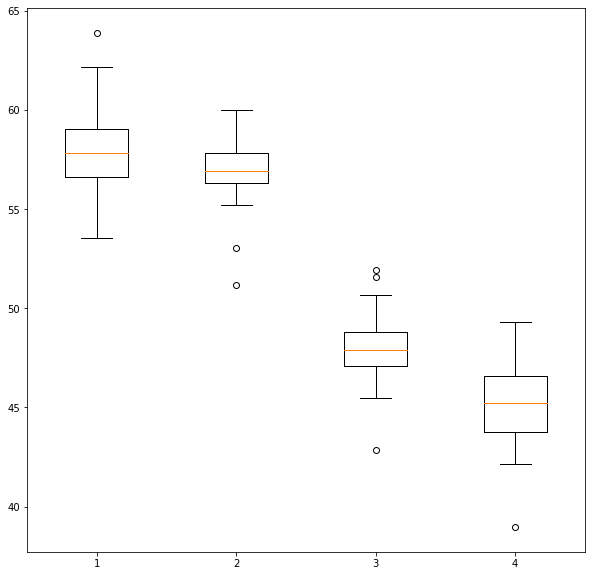

In [627]:
plt.figure(figsize=(10, 10))

plt.boxplot([pc2_pos.max_temp_f, pc2_neg.max_temp_f, pc2_pos.min_temp_f, pc2_neg.min_temp_f])

## Analysis Per Quadrant

In [617]:
min_amplitude = 0.75
cod = wet_with_pcs.pc1 ** 2 + wet_with_pcs.pc2 ** 2 < min_amplitude ** 2
threshold = 0

# analysis with four quandrants
q1 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q1_anoms = r1.hgt_monthly(500, yearmonths=q1.day, bbox=bbox)

q2 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 > threshold) & ~cod]
_, _, q2_anoms = r1.hgt_monthly(500, yearmonths=q2.day, bbox=bbox)

q3 = wet_with_pcs[(wet_with_pcs.pc1 < -threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q3_anoms = r1.hgt_monthly(500, yearmonths=q3.day, bbox=bbox)

q4 = wet_with_pcs[(wet_with_pcs.pc1 > threshold) & (wet_with_pcs.pc2 < -threshold) & ~cod]
_, _, q4_anoms = r1.hgt_monthly(500, yearmonths=q4.day, bbox=bbox)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


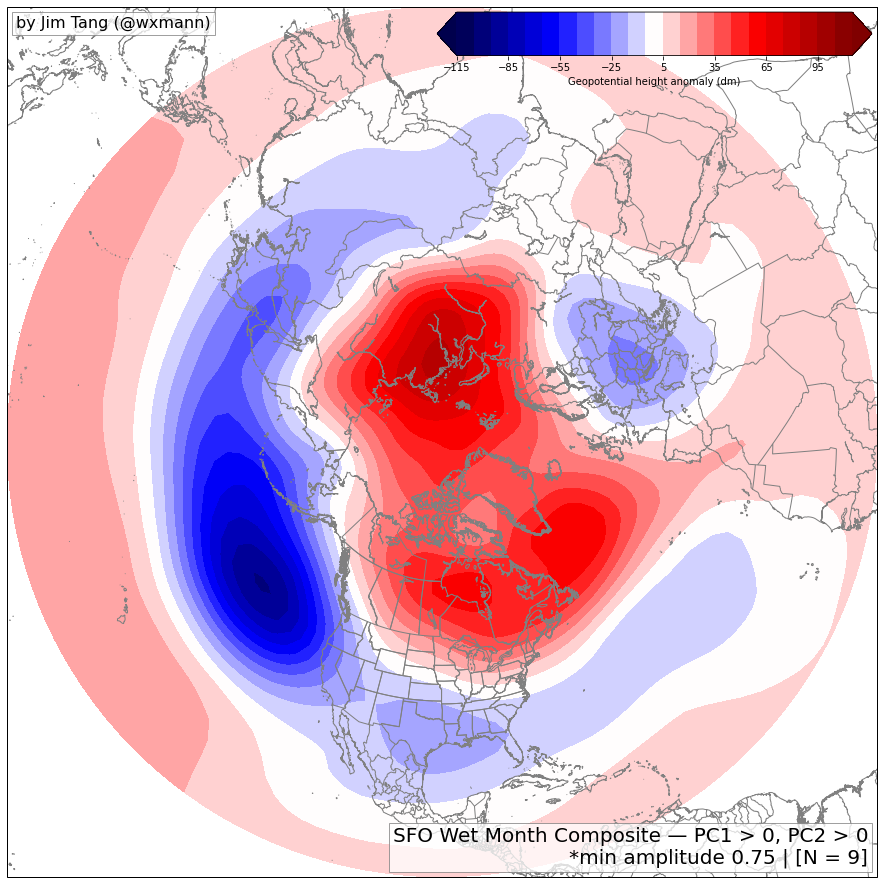

In [618]:
fig = plt.figure(figsize=(16, 16))

da = q1_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q1_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


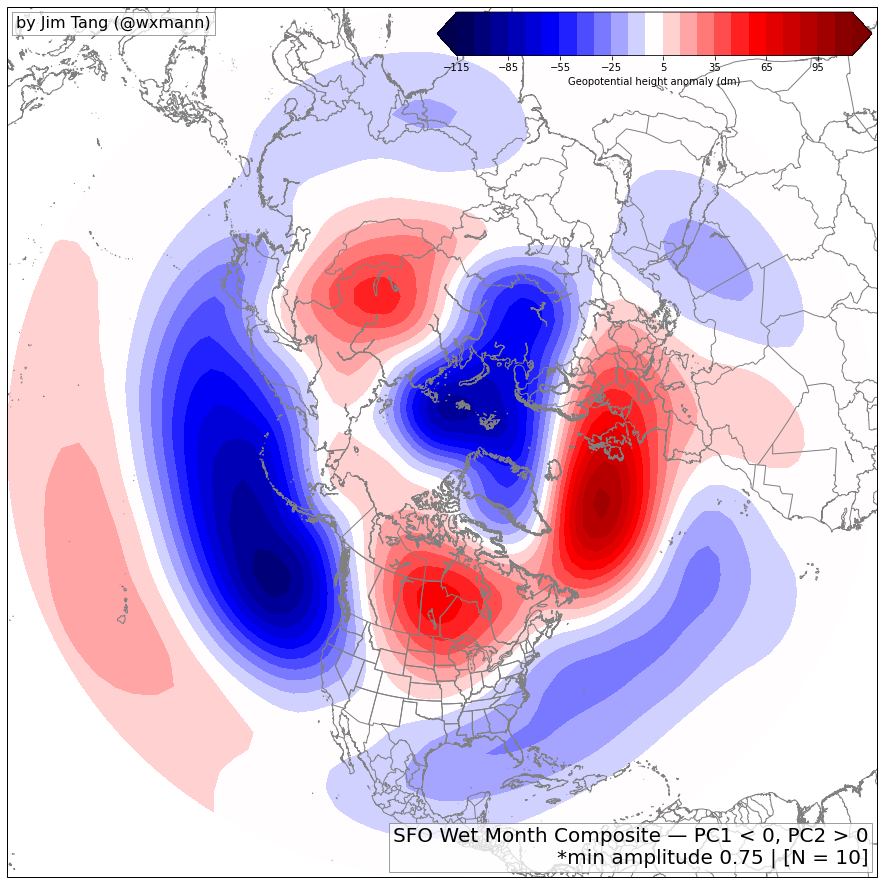

In [619]:
fig = plt.figure(figsize=(16, 16))

da = q2_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 > 0\n*min amplitude {min_amplitude} | [N = {len(q2_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


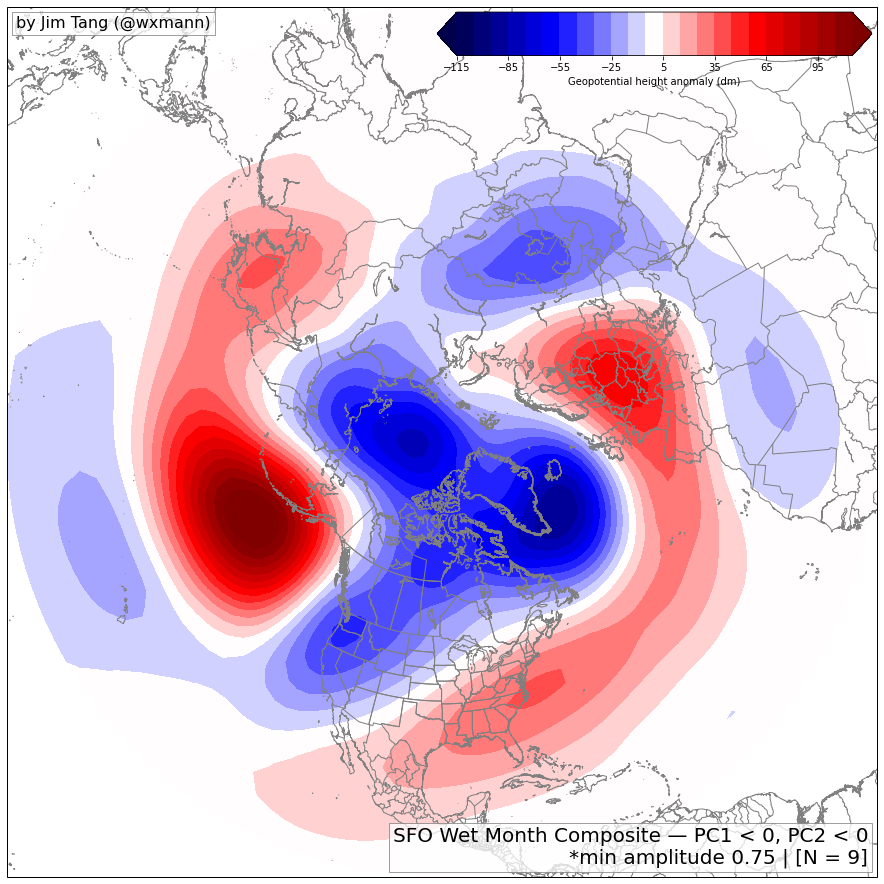

In [620]:
fig = plt.figure(figsize=(16, 16))

da = q3_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 < 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q3_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

/Users/jitang/anaconda/envs/weather-env-2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


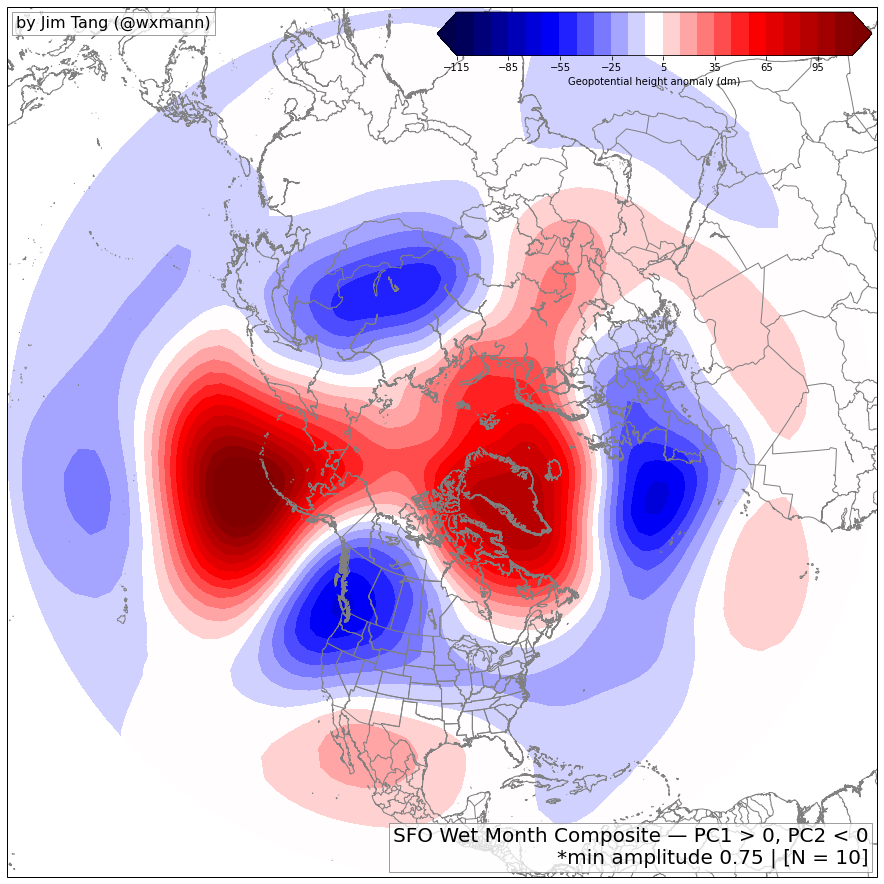

In [621]:
fig = plt.figure(figsize=(16, 16))

da = q4_anoms.mean(dim='time').hgt
cmap = 'seismic'
levels = np.arange(-115, 116, 10)
title = f'SFO Wet Month Composite — PC1 > 0, PC2 < 0\n*min amplitude {min_amplitude} | [N = {len(q4_anoms.time)}]'

m = plot_nhem_anoms(da, cmap, levels, title, draw=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x15fb763d0>,
 'caps': [<matplotlib.lines.Line2D at 0x15fb76a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x15fb76070>,
 'medians': [<matplotlib.lines.Line2D at 0x149673190>,
 'fliers': [<matplotlib.lines.Line2D at 0x1496734f0>,
 'means': []}

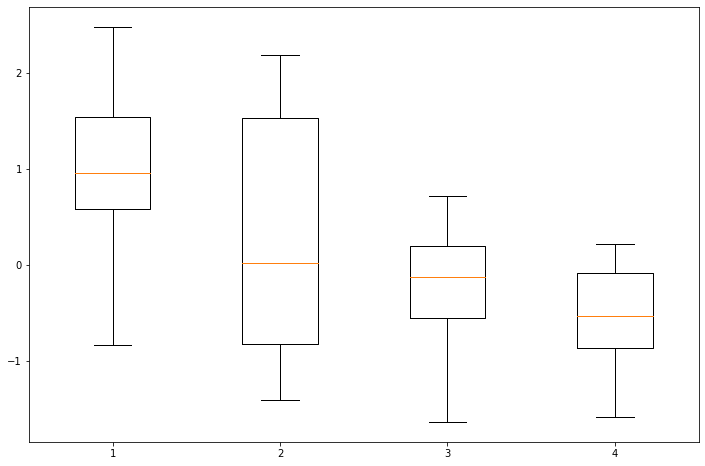

In [622]:
plt.figure(figsize=(12, 8))
plt.boxplot([q1.ONI, q2.ONI, q3.ONI, q4.ONI])

In [623]:
q1

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
2,2014-12-01,10.47,61.580645,51.935484,12,2014,0.66,2014-12-01,0.265425,0.991563
4,2002-12-01,9.37,57.774194,47.612903,12,2002,1.14,2002-12-01,0.736944,0.146873
7,1995-01-01,8.76,56.064516,48.419355,1,1995,0.96,1995-01-01,0.492081,1.046950
9,2001-12-01,8.27,56.032258,47.258065,12,2001,-0.31,2001-12-01,0.766529,0.421736
10,1983-03-01,8.26,59.000000,49.193548,3,1983,1.54,1983-03-01,0.345407,1.666742
11,2005-12-01,8.17,59.032258,47.870968,12,2005,-0.84,2005-12-01,1.326620,1.239700
14,1998-01-01,7.77,57.290323,48.516129,1,1998,2.24,1998-01-01,1.604966,0.650645
40,2016-01-01,5.31,57.000000,48.387097,1,2016,2.48,2016-01-01,2.133837,1.232764
44,2005-02-01,4.82,60.357143,49.571429,2,2005,0.58,2005-02-01,0.958774,0.212885


In [624]:
q2

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
0,1998-02-01,13.52,56.714286,47.750000,2,1998,1.93,1998-02-01,-1.189053,1.421494
12,2000-02-01,8.15,57.827586,48.793103,2,2000,-1.41,2000-02-01,-0.147821,0.828699
16,1997-01-01,7.35,55.129032,46.322581,1,1997,-0.50,1997-01-01,-1.466893,0.298942
20,1983-01-01,6.75,53.548387,42.870968,1,1983,2.18,1983-01-01,-0.769539,1.252666
21,1983-02-01,6.55,58.321429,48.285714,2,1983,1.92,1983-02-01,-0.353400,1.726570
23,1995-12-01,6.27,58.580645,48.806452,12,1995,-0.98,1995-12-01,-0.472982,0.592366
28,2003-12-01,6.09,56.903226,46.870968,12,2003,0.35,2003-12-01,-0.607629,0.753497
37,1981-01-01,5.72,56.612903,45.451613,1,1981,-0.26,1981-01-01,-1.013416,2.524518
41,2011-03-01,5.13,59.870968,47.548387,3,2011,-0.93,2011-03-01,-1.190427,0.472955
48,1993-02-01,4.54,58.107143,47.071429,2,1993,0.30,1993-02-01,-0.864741,0.865122


In [625]:
q3

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
1,1993-01-01,11.07,55.225806,42.967742,1,1993,0.09,1993-01-01,-2.523243,-0.478663
3,2008-01-01,9.87,53.036774,43.682581,1,2008,-1.64,2008-01-01,-0.446672,-1.020879
15,1982-03-01,7.49,56.935484,45.451613,3,1982,0.19,1982-03-01,-0.346280,-1.281874
18,2019-02-01,7.20,55.892857,44.071429,2,2019,0.72,2019-02-01,-0.671778,-1.618002
24,2004-12-01,6.26,58.000000,46.290323,12,2004,0.69,2004-12-01,-0.909202,-0.046062
33,1992-12-01,5.92,55.193548,44.064516,12,1992,-0.13,1992-12-01,-1.268614,-0.969721
34,1986-03-01,5.83,63.774194,50.225806,3,1986,-0.31,1986-03-01,-2.067758,-0.205285
46,2011-02-01,4.79,58.178571,43.000000,2,2011,-1.19,2011-02-01,-0.284883,-2.181632
49,2016-12-01,4.51,56.677419,42.161290,12,2016,-0.56,2016-12-01,-0.485356,-1.226484


In [626]:
q4

,day,precip_in,max_temp_f,min_temp_f,month,year,ONI,time,pc1,pc2
6,1982-01-01,8.80,51.161290,38.967742,1,1982,-0.05,1982-01-01,0.315093,-0.953038
19,1996-01-01,6.84,57.064516,46.580645,1,1996,-0.90,1996-01-01,0.303072,-1.473808
22,1996-12-01,6.49,58.870968,49.290323,12,1996,-0.49,1996-12-01,0.987186,-0.535324
25,2009-02-01,6.24,58.107143,46.035714,2,2009,-0.79,2009-02-01,0.793884,-1.363623
26,2012-12-01,6.23,57.290323,46.387097,12,2012,-0.21,2012-12-01,1.259343,-0.584938
31,1991-03-01,5.96,57.741935,46.580645,3,1991,0.22,1991-03-01,0.474599,-1.333279
35,2010-12-01,5.80,56.709677,47.483871,12,2010,-1.59,2010-12-01,1.796222,-0.401198
39,2006-03-01,5.63,56.935484,43.806452,3,2006,-0.57,2006-03-01,1.921734,-0.551251
42,1994-02-01,5.12,56.535714,44.464286,2,1994,0.07,1994-02-01,0.064838,-1.462110
45,2018-01-01,4.82,59.129032,48.096774,1,2018,-0.92,2018-01-01,1.459969,-0.006932
